# 0. Imports

In [28]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import math

In [29]:
# Set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 1. Hyperparameters

In [30]:
hyperparameters = {
    "gamma" : 0.99,
    "optimizer" : "adam",
    "alpha" : 0.01,
    "episodes" : 1000,
    "verbose" : False,
    "use_tensorboard" : True
}

env_configs = {
    "name" : "CartPole-v1",
    "render_mode": None
}

# 2. Define the torch NN

In [31]:
class PolicyNetwork(nn.Module):
    """
    Class (nn.Module): Simple NN to act as policy learner
    """
    def __init__(self, state_dim: int, action_dim: int):
        """
        Function: Initialises the nn.Module obj to create a policy learner
        Args:
            state_dim (int): Number of state dimension to in env to consider as obervable
            action_dim (int): Number of action dimensions to output the action probablities
        Returns: None
        """

        super(PolicyNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        """
        Function: Forward loop of the policy learner
        Args: 
            state (tensor): It contains the following features
                - x : Position of the cart from the center
                - x_dot : Velocity of the cart horizontally
                - theeta : Pole Angle from the vertical
                - theeta_dot : Angular velocity of the pole

        Return: 
            action (tensor): Outputs a vector with the probablities of the actions that can be taken
        """
        return self.net(state)

# 3. Helper Function

In [32]:
def compute_returns(rewards: torch.tensor, gamma: torch.float32 = 0.99):
    """
    Function: Collects the final reward at the end of an episode and back computes the return of each state
    Args:
        rewards (tensor): The rewards at each step of the episode
        gamma (float): Factor to discount the rewards with increase of time
    """
    
    # Initialise the Return  as 0
    # Initialise the returns as empty
    returns = []
    G = 0

    # Reverse the rewards and back compute the return
    # Keep on appending the returns at the first position to get a correctly ordered list
    for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)

    return returns

# 3. Training Loop

In [33]:
def train(env_name: str, 
        env_render_mode: str, 
        gamma: torch.float32, 
        alpha: torch.float32, 
        episodes: int,
        device: str = "cuda",
        verbose: bool = True,
        use_tensorboard: bool = False): 
    """
    Function: A training loop to train the policy learner for teh cartpole environment
    Args:   
        env_name (str): Name of the environment to setup
        gamma (torch.float32): The discount factor to apply when calculating returns
        alpha (torch.float32): The learning rate of the policy learner NN
        episodes (int): The number of episodes to train the model on
        device (str): Specifies the compute unit
        verbose (bool): Prints the rewards during training while True
        use_tensorboard (bool): Log the results to tensorboard if True
    Returns:
        all_rewards (tensor): Collection of all rewards in the various episodes and steps
    """

    # Initialise the environment and get the state and action dimensions
    env = gym.make(env_name, render_mode=env_render_mode)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n


    # Define the policy learner and optimizer 
    # Define the all rewards tensor
    # Define the tensor board summary writer
    # 
    policy = PolicyNetwork(state_dim, action_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=alpha)
    all_rewards = []
    avg_rewards = []
    writer = SummaryWriter(log_dir=f"runs/REINFORCE_CartPole_run_{math.floor(time.time())}") if use_tensorboard else None

    # Define the episode loop
    for episode in tqdm(range(episodes)):
        
        # Reset the env
        # Define the termination flag
        # Define the log probs
        # Define the rewards list
        state, _ = env.reset()
        done = False
        log_probs = []
        rewards = []

        # Define the step loop
        # Runs till termination or truncation
        while not done:

            # Make the policy learner produce the action probablities based on the state 
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            action_probs = policy(state_tensor)

            # Select an action based on the probablities given by the policy learner
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            # Append the log probablity to the log_probs list
            log_probs.append(dist.log_prob(action))

            # Get the next state information by taking a step 
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Reward append and move to the next state
            rewards.append(reward)
            state = next_state

        # Compute discounted returns
        returns = compute_returns(rewards=rewards, gamma=gamma)
        returns = torch.tensor(returns).to(device)

        # Normalise returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute the loss
        # Update the policy learner
        # Produce the total rewards
        loss = -torch.sum(torch.stack(log_probs) * returns)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_rewards = sum(rewards)
        all_rewards.append(total_rewards)

        # TensorBoard logging
        writer.add_scalar("Reward/Total", total_rewards, episode)
        if episode >= 100 and use_tensorboard:
            avg_reward = np.mean(all_rewards[-100:])
            sum_reward = np.sum(all_rewards[-100:])
            max_reward = np.sum(all_rewards[-100:])
            writer.add_scalar("Reward/Avg100", avg_reward, episode)
            writer.add_scalar("Reward/Sum100", sum_reward, episode)
            writer.add_scalar("Reward/Max100", max_reward, episode)
            avg_rewards.append(avg_reward)

        # Print reward for every 50th episode
        if episode % 50 == 0 and verbose:
            print(f"Episode {episode} — Total Reward: {total_rewards}")

    writer.close
    env.close()
    return all_rewards

# 4. SANDBOX

In [ ]:
rewards = train(env_name = env_configs['name'], 
        env_render_mode = env_configs['render_mode'], 
        gamma = hyperparameters['gamma'], 
        alpha = hyperparameters['alpha'], 
        episodes = hyperparameters['episodes'],
        device = device,
        verbose = hyperparameters['verbose'],
        use_tensorboard = hyperparameters['use_tensorboard']
)

  0%|          | 0/1000 [00:00<?, ?it/s]

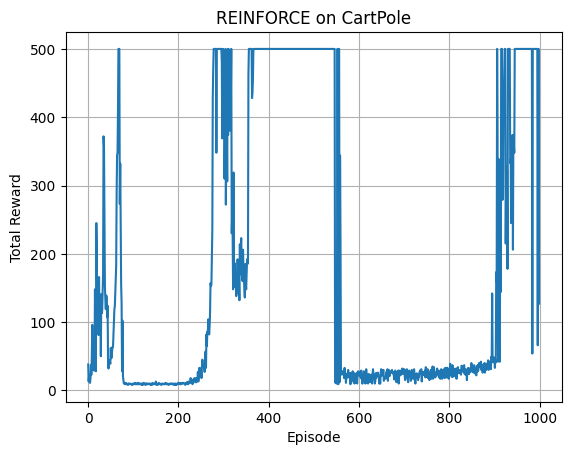

In [51]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE on CartPole')
plt.grid()
plt.show()